# UMAP Reproducibility

UMAP is a stochastic algorithm -- it makes use of randomness both to speed up approximation steps, and to aid in solving hard optimization problems. This means that different runs of UMAP can produce different results. UMAP is relatively stable -- thus the variance between runs should ideally be relatively small -- but different runs may have variations none the less. To ensure that results can be reproduced exactly UMAP allows the user to set a random seed state. 

Since version 0.4 UMAP also support multi-threading for faster performance; when performing optimization this exploits the fact that race conditions between the threads are acceptable within certain optimization phases. Unfortunately this means that the randomness in UMAP output for the multi-threaded case depends not only on the random seed input, but also on race conditions between thereads during optimization, over which no control can be had. This means that multi-threaded UMAP results cannot be explicitly reproduced.

In this tutorial we'll look at how UMAP can be used in multi-threaded mode for performance purposes, and alternatively how we can fix random states to ensure exact reproducibility at the cost of some performance. First let's load the relevant libraries and get some data; in this case the MNIST digits dataset.

In [1]:
import numpy as np
import sklearn.datasets
import umap
import umap.plot

In [2]:
data, labels = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

With data in hand let's run UMAP on it, and note how long it takes to run:

In [3]:
%%time
mapper1 = umap.UMAP().fit(data)

CPU times: user 3min 18s, sys: 3.84 s, total: 3min 22s
Wall time: 1min 29s


The thing to note here is that the "Wall time" is significantly smaller than the CPU time -- this means that multiple CPU cores were used. For this particular demonstration I am making use of the latest version of PyNNDescent for nearest neighbor search (UMAP will use it if you have it installed) which supports multi-threading as well. The result is a very fast fitting to the data that does an effective job of using several cores. If you are on a large server with many cores available and don't wish to use them *all* (which is the default situtation) you can currently control the number of cores used by setting the numba environment variable ``NUMBA_NUM_THREADS``; see the [numba documentation](https://numba.pydata.org/numba-doc/dev/reference/envvars.html#threading-control) for more details.

Now let's plot our result to see what the embedding looks like:

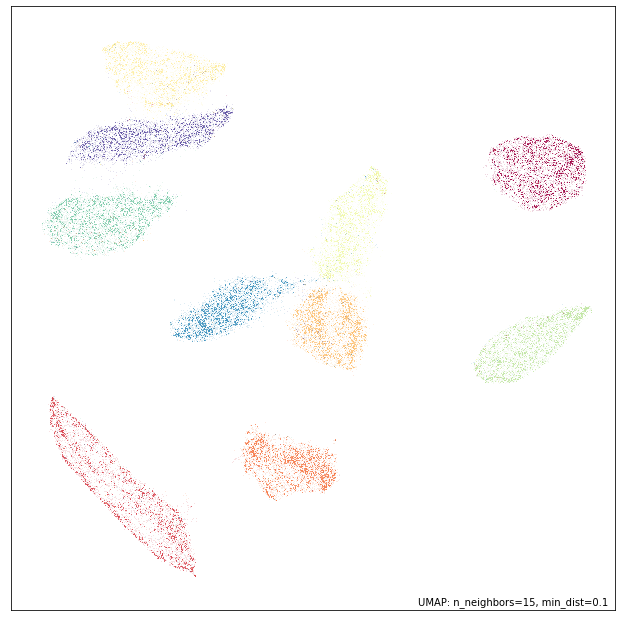

In [4]:
umap.plot.points(mapper1, labels=labels)

Now, let's run UMAP again and compare the results to that of our first run.

In [5]:
%%time
mapper2 = umap.UMAP().fit(data)

CPU times: user 2min 53s, sys: 4.16 s, total: 2min 57s
Wall time: 1min 5s


You will note that this time we ran *even faster*. This is because during the first run numba was still JIT compiling some of the code in the background. In contrast, this time that work has already been done, so it no longer takes up any of our run-time. We see that we are still making use of mutliple cores well.

Now let's plot the results of this second run and compare to the first:

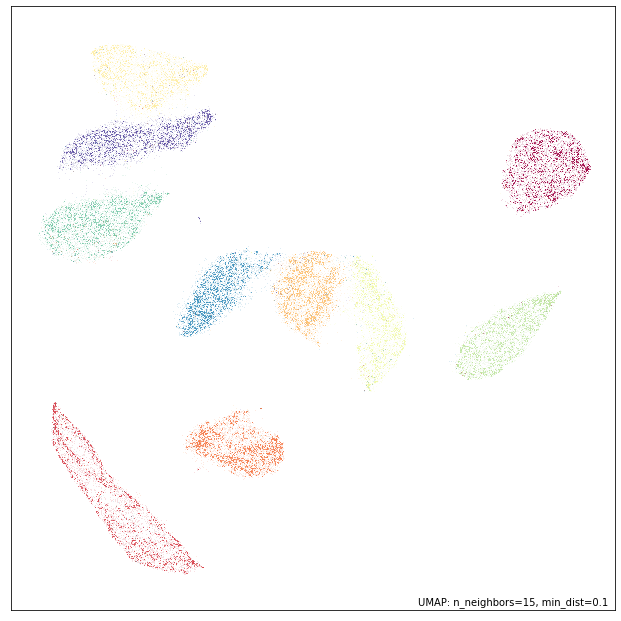

In [6]:
umap.plot.points(mapper2, labels=labels)

Qualitatively this looks very similar, but a little closer inspection will quickly show that the results are actually different between the runs. Note that even in versions of UMAP prior to 0.4 this would have been the case -- since we fixed no specific random seed, and were thus using the current random state of the system which will ntaurally differ between runs. This is the default behaviour, as is standard with sklearn estimators that are stochastic. Rather than having a default random seed the user is required to explicitly provide one should they want a reproducible result. As noted by Vito Zanotelli 

> ... setting a random seed is like signing a waiver "I am aware that this is a stochastic algorithm and I have done sufficient tests to confirm that my main conclusions are not affected by this randomess".

With that in mind, let's see what happens if we set an explicit ``random_state`` value:

In [7]:
%%time
mapper3 = umap.UMAP(random_state=42).fit(data)

CPU times: user 2min 27s, sys: 4.16 s, total: 2min 31s
Wall time: 1min 56s


The first thing to note that that this run took signifcantly longer (despite having all the functions JIT compiled by numba already). Then note that the Wall time and CPU times are now much closer to each other -- we are not longer exploiting multiple cores to anywhere near the same degree. This is because by setting a ``random_state`` we are effectively turning off any of the multi-threading that does not support explicit reproducibility. Let's plot the results:

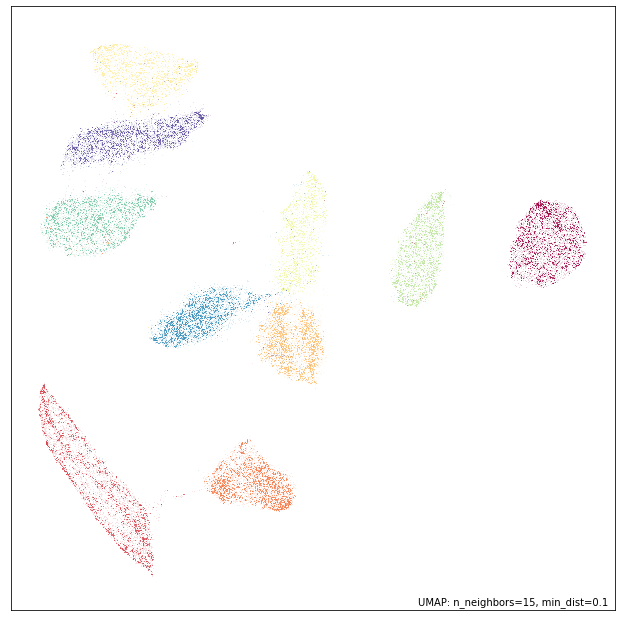

In [8]:
umap.plot.points(mapper3, labels=labels)

We arrive at much the same results as before from a qualitative point of view, but again inspection will show that there are some differences. More importantly this result should now be reproducible. Thus we can run UMAP again, with the same ``random_state`` set ...

In [9]:
%%time
mapper4 = umap.UMAP(random_state=42).fit(data)

CPU times: user 2min 26s, sys: 4.13 s, total: 2min 30s
Wall time: 1min 54s


Again, this takes longer than the earlier runs with no ``random_state`` set. However when we plot the results of the second run we see that they look not merely qualitatively similar, but instead appear to be almost identical:

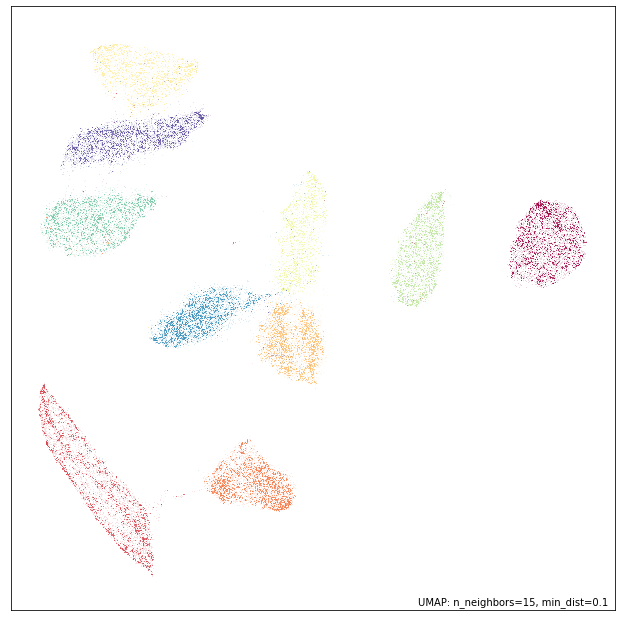

In [10]:
umap.plot.points(mapper4, labels=labels)

We can, in fact, check that the results are identical by verifying that each and every coordinate of the resulting embeddings match perfectly:

In [11]:
np.all(mapper3.embedding_ == mapper4.embedding_)

True

So we have, in fact, reproduced the embedding exactly. 